In [21]:
import io
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
capture_file = pd.read_csv("/content/arpcode (13).csv")
X = capture_file[['Time', 'Source', 'Destination', 'Protocol']]
Y = capture_file['Info']

In [23]:
X.shape

(3160, 4)

In [24]:
X_Time_en = MinMaxScaler()
X_Source_en = LabelEncoder()
X_Destination_en = LabelEncoder()
X_Protocol_en = LabelEncoder()

X['dt_Time'] = X_Time_en.fit_transform(X[['Time']])
X['dt_Source'] = X_Source_en.fit_transform(X['Source'])
X['dt_Destination'] = X_Destination_en.fit_transform(X['Destination'])
X['dt_Protocol'] = X_Protocol_en.fit_transform(X['Protocol'])

<ipython-input-24-2e711e491a2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dt_Time'] = X_Time_en.fit_transform(X[['Time']])


In [25]:
X_input = X.drop(['Source', 'Destination', 'Protocol', 'Time'], axis=1)


In [26]:

# mean = X_input.mean(axis=0)
# std = X_input.std(axis=0)
# X_input = (X_input - mean) / std

In [27]:
X_input = X_input.values

In [28]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size - 1])  # Label for the last packet in the window
    return np.array(X_seq), np.array(y_seq)

In [29]:
window_size = 5
X_sequences, y_sequences = create_sequences(X_input, Y.values, window_size)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [31]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1893, 5, 4), (631, 5, 4), (631, 5, 4), (1893,), (631,), (631,))

In [32]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [33]:
X_train.shape[1]

5

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
print(X_train.shape[1])
print(X_train.shape[2])

5
4


In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
                    class_weight=class_weight_dict,
                    shuffle = False)

Epoch 1/500
60/60 [==============================] - 6s 34ms/step - loss: 0.6659 - accuracy: 0.5610 - val_loss: 0.7145 - val_accuracy: 0.3835
Epoch 2/500
60/60 [==============================] - 1s 16ms/step - loss: 0.4860 - accuracy: 0.7934 - val_loss: 0.2873 - val_accuracy: 0.8605
Epoch 3/500
60/60 [==============================] - 1s 18ms/step - loss: 0.3248 - accuracy: 0.8674 - val_loss: 0.2543 - val_accuracy: 0.8637
Epoch 4/500
60/60 [==============================] - 1s 18ms/step - loss: 0.3042 - accuracy: 0.8663 - val_loss: 0.2550 - val_accuracy: 0.8558
Epoch 5/500
60/60 [==============================] - 1s 14ms/step - loss: 0.3041 - accuracy: 0.8648 - val_loss: 0.2910 - val_accuracy: 0.8542
Epoch 6/500
60/60 [==============================] - 1s 12ms/step - loss: 0.2997 - accuracy: 0.8627 - val_loss: 0.3113 - val_accuracy: 0.8526
Epoch 7/500
60/60 [==============================] - 1s 13ms/step - loss: 0.2981 - accuracy: 0.8616 - val_loss: 0.3245 - val_accuracy: 0.8526
Epoch 

In [38]:
# Predictions
prediction = model.predict(X_test)
prediction_binary = prediction.round().astype(int)

20/20 [==============================] - 2s 6ms/step


In [39]:
# Evaluation
accu = accuracy_score(y_test, prediction_binary)
accu = accu*100;
precision = precision_score(y_test, prediction_binary)
f1 = f1_score(y_test, prediction_binary)

print(f"Accuracy: {accu}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 98.8906497622821
Precision: 0.9104477611940298
F1 Score: 0.9457364341085271


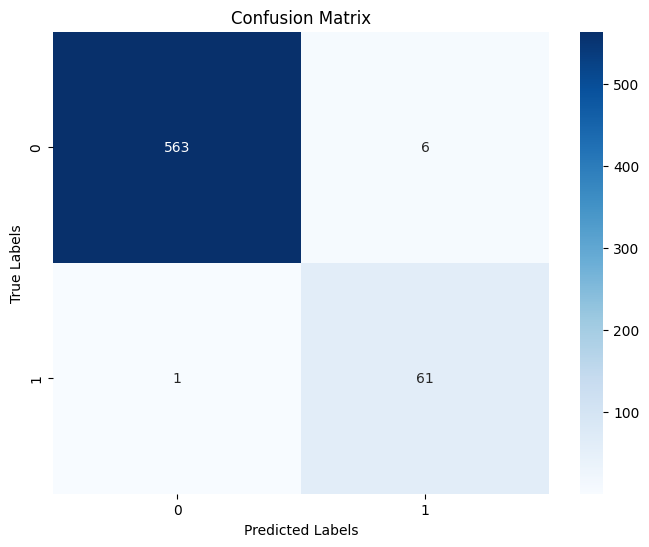

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, prediction_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()